In [24]:
import pandas as pd
import numpy as np

# Read the data
acxiom_demo = pd.read_csv('data/cf_acxiomAppend_va2_10_14_2022.csv')
PII_hearttable = pd.read_csv('data/dev_sample_HeartTable_10_17_2022.csv')
agr_demo = pd.read_csv('data/cf_agrAppend_va2_10_14_2022.csv')

C:\Users\cayde\AppData\Local\Temp\ipykernel_16336\1825738127.py:7: DtypeWarning: Columns (12,66) have mixed types. Specify dtype option on import or set low_memory=False.
  agr_demo = pd.read_csv('data/cf_agrAppend_va2_10_14_2022.csv')


# PII heatrable data and handling class labels
overview
- the modeling version of this dataset will have all nonpredictive pii elements dropped like name dob things of the sort
- we will be augmenting the class labels so that we only have 1 class label of suicide populations 1 yes 0 no. We will do this because there is 100% correlation between suicide populations and living population(you cant be alive if you killed yourself) so 1 label lets you know the other label.


In [25]:

# need to add a class flag to the PII_hearttable

# using regex count the number of times the substring "agr" appears in the column 'source_id'
# PII_hearttable['source_id'].str.count('agr').sum()

# if the coulumn 'source_id' contains the substring "agr" then the class is 1 else 2
PII_hearttable['is_suicide'] = np.where(PII_hearttable['source_id'].str.contains('agr'), 0, 1)

In [26]:
# need to drop all non predictive pii info as it wont help the model.
# only keep columns 'source_id' and 'is_suicide' from dataset pii_hearttable
PII_hearttable = PII_hearttable[['source_id', 'is_suicide']]


In [27]:
# there are 2 rows '6080_(medical_source)index_4232', and '6990_(medical_source)index_4966' that do not have a class label
# grab all the rows with duplicate indexs in dataframe acxiom demo
acxiom_demo[acxiom_demo.duplicated(subset=['source_id'], keep=False)]

,PK,source_id,FIRST_NAME,LAST_NAME,MASTER_DOB,ADDRESS,CITY,STATE,ZIP,IBE8637,...,IBE1273_02,miACS_12_003,miACS_12_004,miACS_11_046,miACS_19_048,IBE7606_01,SUP1016,miACS_00_001,IBE7606_02,AP006203
19481,19481,4407_(medical_source)index_2310,HOWARD,MEEKS,3/7/44,2929 N 101ST ST W,MUSKOGEE,OK,74401-7225,5,...,E,45.0,4.0,3.43,599.0,O,NaN,2681.0,3,12.0
19482,19482,4408_(medical_source)index_6634,HOWARD,MEEKS,3/7/44,2929 N 101ST ST W,MUSKOGEE,OK,74401-7225,5,...,E,45.0,4.0,3.43,599.0,O,NaN,2681.0,3,12.0
21394,21394,4407_(medical_source)index_2310,HOWARD,MEEKS,8/16/63,2929 N 101ST ST W,MUSKOGEE,OK,74401-7225,5,...,E,45.0,4.0,3.43,599.0,O,NaN,2681.0,3,12.0
21395,21395,4408_(medical_source)index_6634,HOWARD,MEEKS,8/16/63,2929 N 101ST ST W,MUSKOGEE,OK,74401-7225,5,...,E,45.0,4.0,3.43,599.0,O,NaN,2681.0,3,12.0


# Acxiom demo data
overview
- drop all non predictive pii data
- try to backfill every row with missing data




In [28]:
# adding label to each dataset so we can look at correlation between predictors and label

# join the tables is_suicide_df and acxiom_demo on the column 'source_id'
acxiom_demo = pd.merge(acxiom_demo, PII_hearttable, on='source_id')

In [29]:
# drop the columns 'PK', 'FIRST_NAME', 'LAST_NAME', 'MASTER_DOB', 'ADDRESS', 'CITY', 'STATE', 'ZIP'
acxiom_demo = acxiom_demo.drop(['PK', 'FIRST_NAME', 'LAST_NAME', 'MASTER_DOB', 'ADDRESS', 'CITY', 'STATE', 'ZIP'], axis=1)

In [30]:
# here we will rename ever column with a better description of the contents of it for faster interpritability. 
# create a dictionary
dict = {
    'Occupation - Person': 'IBE8637',
    'Generations in Household': 'IBE8652',
    'Single Parent': 'IBE2351',
    'Senior Adult in Household': 'IBE8692',
    'Young Adult in Household': 'IBE8680',
    'Marital Status in the Household - 100%': 'IBE7609_01',
    'Presence of Children - 100%': 'IBE7622_01',
    'Education - 1st Person in Household - 100%': 'IBE7650_01',
    'Guns and Ammunition': 'IBE6423',
    'Hunting': 'IBE6518',
    'Underbanked': 'IBE9351',
    'Economic Stability Indicator': 'IBE9350',
    'Population Density': 'IBE1273_01',
    'Population 15+ - % Separated or Divorced': 'miACS_12_003',
    'Population 15+ - % Widowed': 'miACS_12_004',
    'Families - Average Size': 'miACS_11_046',
    'Family - Average Income (in hundreds of $US)': 'miACS_19_048',
    'Home Owner / Renter - 100%': 'IBE7606_01',
    'Suppression - Deceased, Bankruptcy, TLJ - Highest': 'SUP1016',
    'Number of People (Total Population)': 'miACS_00_001',
    'Power Video Gamer': 'AP006203'
}

# create another dictionary with key and value swapped
dict2 = {v: k for k, v in dict.items()}

# go through the dataframe and replace the column names with the new column names
for col in acxiom_demo.columns:
    if col in dict2:
        acxiom_demo = acxiom_demo.rename(columns={col: dict2[col]})


In [31]:
# there are several attributes that are precsion levels of other attributes. they can be identified by the substring '_02' in the column name. i will be dropping these columns.
acxiom_demo = acxiom_demo.loc[:, ~acxiom_demo.columns.str.contains('_02')]

# handling missing data attribute by attribute 
columns i need to come back to 
- occupation


In [32]:
# in this code block i will be trying to impute the missing values in the dataset attribute by attribute.
# get the percentage of missing values in each column
print(acxiom_demo.isnull().sum() / len(acxiom_demo))

source_id                                            0.000000
Occupation - Person                                  0.566965
Generations in Household                             0.252667
Single Parent                                        0.903003
Senior Adult in Household                            0.889153
Young Adult in Household                             0.952039
Marital Status in the Household - 100%               0.056253
Presence of Children - 100%                          0.056253
Education - 1st Person in Household - 100%           0.056253
Guns and Ammunition                                  0.985074
Hunting                                              0.998073
Underbanked                                          0.222411
Economic Stability Indicator                         0.222411
Population Density                                   0.047423
Population 15+ - % Separated or Divorced             0.047423
Population 15+ - % Widowed                           0.047423
Families

In [33]:
# Occupation - Person
# Occupation - Person is categorical and will need to be 1 hot encoded at the end. 
# in terms of imputation there could be some combination of other datapoints to backfill this column. 
# for instance from agr data we could use estimated income credit rating to backfill this column.

# 1 hot encode the column Occupation - Person
acxiom_demo = pd.get_dummies(acxiom_demo, columns=['Occupation - Person'])

In [34]:
# Generations in Household
# Generations in Household is numerical and does not need to be standardized. 
# there is a sub-project here to impute the missing values in this column. use generations in household as output and see if other columns can be used as input to predict the missing values.
# for now lets try 1 hot encoding the column Generations in Household and see if it helps the model.

# print Generations in Household is numerical and does not need to be standardized.
print("Generations in Household is numerical and does not need to be standardized.\n")

# how many missing values are there in the column Generations in Household
print("missing values in Generations in Household: ", acxiom_demo['Generations in Household'].isnull().sum())
# in precentage with nice formatting
print("percent missing values in Generations in Household: ", f"{acxiom_demo['Generations in Household'].isnull().sum() / len(acxiom_demo):.2%}")

# 1 hot encode the column Generations in Household
acxiom_demo = pd.get_dummies(acxiom_demo, columns=['Generations in Household'])

# import scikit learn libraries for the task of classification 



Generations in Household is numerical and does not need to be standardized.

missing values in Generations in Household:  5637
percent missing values in Generations in Household:  25.27%


In [35]:
# single parent
# boolean Indicates that a single parent exists in the household. filled all nans with 0

# how many missing values in 'single parent'
acxiom_demo['Single Parent'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Single Parent'].isnull().sum()/len(acxiom_demo)))

# make it so there are no nan's in dataframe replace them with 0's
acxiom_demo['Single Parent'] = acxiom_demo['Single Parent'].fillna(0)

# how many missing values in 'single parent'
acxiom_demo['Single Parent'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Single Parent'].isnull().sum()/len(acxiom_demo)))

nan's: 90.3%
nan's: 0.0%


In [36]:
# 'Senior Adult in Household'
# description: If in the household there is a person over age 55 and a person over age 25, and there is at least 18 years difference between them, then turn on ‘Senior in Household’.
# boolean Indicates that a senior adult exists in the household. filled all nans with 0

# how many missing values in 'Senior Adult in Household'
acxiom_demo['Senior Adult in Household'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Senior Adult in Household'].isnull().sum()/len(acxiom_demo)))

# make it so there are no nan's in dataframe replace them with 0's
acxiom_demo['Senior Adult in Household'] = acxiom_demo['Senior Adult in Household'].fillna(0)

# how many missing values in 'Senior Adult in Household'
acxiom_demo['Senior Adult in Household'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Senior Adult in Household'].isnull().sum()/len(acxiom_demo)))

# change the 'Y' to 1 and 'N' to 0
acxiom_demo['Senior Adult in Household'] = acxiom_demo['Senior Adult in Household'].replace({'Y': 1, 'N': 0})



nan's: 88.9%
nan's: 0.0%


In [37]:
# 'Young Adult in Household'
# description: Indicates that there is a young adult in the household where another adult is identified as the 1st individual. (Young adult is ages 18 to 25.)
# boolean Indicates that a young adult exists in the household. filled all nans with 0

# how many missing values in 'Young Adult in Household'
acxiom_demo['Young Adult in Household'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Young Adult in Household'].isnull().sum()/len(acxiom_demo)))

# make it so there are no nan's in dataframe replace them with 0's
acxiom_demo['Young Adult in Household'] = acxiom_demo['Young Adult in Household'].fillna(0)

# how many missing values in 'Young Adult in Household'
acxiom_demo['Young Adult in Household'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Young Adult in Household'].isnull().sum()/len(acxiom_demo)))

# change the 'Y' to 1 and 'N' to 0
acxiom_demo['Young Adult in Household'] = acxiom_demo['Young Adult in Household'].replace({'Y': 1, 'N': 0})

nan's: 95.2%
nan's: 0.0%


In [38]:
# 'Marital Status in the Household - 100%'
# description: Indicates whether anyone in the household is married.  This element includes 1) 9609 Marital Status in the Household, 2) business rule inferences that create Inferred Married and Inferred Single, 3) inferred/modeled data that fills in missing data by inferring marital status coverage up to the household level match rate of the file being appended, and 4) a mode calculation of the ZIP+4 and ZIP.
    # 1) For the 8609 Marital Status portion, it is fed by consumer self-reported marital data.
    # 2) Inferred Married and Inferred Single, values A and B, are inferred based on business rules.Inferred Married - When the marital status of Married or Single cannot be determined from a source and there are 2 names in the household with gender of Male and Female, within a certain age range of each other, then marital status is set to A "Inferred Married".  Inferred Single - When the marital status of Married or Single cannot be determined from a source and there is only one name in the household, then the marital status is set to B "Inferred Single".
    # 3) Inferred/Modeled data is used to fill in married and single values up to the household match rate.
    # 4) Mode calculations of married and single at the ZIP+4 and ZIP levels are used to fill in married and single values to increase coverage up to 100%.
# categorical variable with 5 categories. need to 1 hot encode

# how many missing values in 'Marital Status in the Household - 100%'
acxiom_demo['Marital Status in the Household - 100%'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Marital Status in the Household - 100%'].isnull().sum()/len(acxiom_demo)))

# one hot encode the 'Marital Status in the Household - 100%' column
acxiom_demo = pd.get_dummies(acxiom_demo, columns=['Marital Status in the Household - 100%'])

nan's: 5.6%


In [39]:
# 'Presence of Children - 100%'
# description: Indicates the presence of children in the household. Includes inferred data added to No Children Present to extend the coverage to the household level and includes the mode of the ZIP9 and ZIP to extend the coverage to 100%.
    # This element includes 2 fields, 7622_01 which indicates the presence of children, and 7622_02 which is the precision indicating the level of data that was appended.
    # This 7622 Presence of Children includes a calculated mode of Presence of Children from the ZIP9 and ZIP which brings the coverage up to 100%.  The basis of this element is 9622 Presence of Children.  Calculating the mode of the ZIP9 and ZIP can add data to both Yes Children Present and No Children Present values.
    # NOTE: The children's names are not provided by the sources.  The logic gathers the children's ages from across all the sources into a table to net the data to only the children's ages that exist in a household.  Proprietary logic calculates the netting.  The resulting ages are then populated into the children's age elements, then counted to populate the number of children element and the presence of children element.  Sources that provide an actual Presence of Children also contribute.
    # NOTE: Household level Children's age less than age 16 and gender data in the state of California will have reduced coverage due to the California Consumer Privacy Act (CCPA) regulations.
# categorical variable with 2 categories. need to 1 hot encode

# how many missing values in 'Presence of Children - 100%'
acxiom_demo['Presence of Children - 100%'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Presence of Children - 100%'].isnull().sum()/len(acxiom_demo)))

# one hot encode the 'Presence of Children - 100%' column
acxiom_demo = pd.get_dummies(acxiom_demo, columns=['Presence of Children - 100%'])

nan's: 5.6%


In [40]:
# 'Education - 1st Person in Household - 100%'
# description: Indicates the highest known education of the 1st ranked person in the household.  The ranking is based on a series of InfoBase ranking rules.  This element is based on 9650 Education-1st Person in the Household PLUS. It includes inferred/modeled data to increase coverage up to the household match rate, and includes the mode calculation of the ZIP+4 and ZIP to increase coverage up to 100%.
# numeric attribute. fill in missing values with median value

# how many missing values in 'Education - 1st Person in Household - 100%'
acxiom_demo['Education - 1st Person in Household - 100%'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Education - 1st Person in Household - 100%'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Education - 1st Person in Household - 100%' column look like
print(acxiom_demo['Education - 1st Person in Household - 100%'].value_counts())

# what is the meadian value of the 'Education - 1st Person in Household - 100%' column
acxiom_demo['Education - 1st Person in Household - 100%'].median()

# fill in the missing values with the median value
acxiom_demo['Education - 1st Person in Household - 100%'] = acxiom_demo['Education - 1st Person in Household - 100%'].fillna(acxiom_demo['Education - 1st Person in Household - 100%'].median())


nan's: 5.6%
1.0    13588
2.0     4813
3.0     2528
4.0      126
Name: Education - 1st Person in Household - 100%, dtype: int64


In [41]:
# 'Guns and Ammunition'
# description: A purchase of Guns and Ammunition has occurred within the last 24 months in the Household. The Buying Activity data has been summarized into a categorical level according to purchase activity. This removes certain point-of-sale information, such as SKUs (stock keeping unit) but allows visibility into types of purchases and buying behaviors within the Household.
# boolean variable. fill in missing values with 0

# how many missing values in 'Guns and Ammunition'
acxiom_demo['Guns and Ammunition'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Guns and Ammunition'].isnull().sum()/len(acxiom_demo)))

# fill in nan's with 0
acxiom_demo['Guns and Ammunition'] = acxiom_demo['Guns and Ammunition'].fillna(0)

nan's: 98.5%


In [42]:
# 'Hunting'
# desc: A purchase of Hunting products in Sports & Leisure has occurred within the last 24 months in the Household. The Buying Activity data has been summarized into a categorical level according to purchase activity. This removes certain point-of-sale information, such as SKUs (stock keeping unit) but allows visibility into types of purchases and buying behaviors within the Household.
# boolean variable. fill in missing values with 0

# how many missing values in 'Hunting'
acxiom_demo['Hunting'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Hunting'].isnull().sum()/len(acxiom_demo)))

# fill in nan's with 0
acxiom_demo['Hunting'] = acxiom_demo['Hunting'].fillna(0)


nan's: 99.8%


In [43]:
# 'Underbanked'
# desc: The UnderBanked Indicator model is an easy to apply model score that indicates the likelihood a consumer relies primarily on cash transactions and has no formal banking relationships. UnderBanked is built using non-credit data.
# numeric attribute. for now i am filling in with the median value. we can take a closer look at this later to use other attributes to predict the missing values for possible better performance

# 20 degrees is to high lets lower it to 5 degrees
# 1-4 = 1
# 5-8 = 2
# 9-12 = 3
# 13-16 = 4
# 17-20 = 5

# how many missing values in 'Underbanked'
acxiom_demo['Underbanked'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Underbanked'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Underbanked' column look like
print(acxiom_demo['Underbanked'].value_counts())

# what is the meadian value of the 'Underbanked' column
print(acxiom_demo['Underbanked'].median())

acxiom_demo['Underbanked'] = acxiom_demo['Underbanked'].apply(lambda x: 1 if x <= 4 else 2 if x <= 8 else 3 if x <= 12 else 4 if x <= 16 else 5)

# what does the distribution of the 'Underbanked' column look like
print(acxiom_demo['Underbanked'].value_counts())

# fill in the missing values with the median value
acxiom_demo['Underbanked'] = acxiom_demo['Underbanked'].fillna(acxiom_demo['Underbanked'].median())

# what is the correlation between the 'Underbanked' column and 'is_suicide' column
corr = acxiom_demo['Underbanked'].corr(acxiom_demo['is_suicide'])
print("Correlation between Underbanked and is_suicide is: ", corr)


nan's: 22.2%
18.0    1062
17.0    1031
13.0    1004
10.0     976
12.0     973
16.0     953
11.0     951
15.0     942
9.0      921
8.0      918
19.0     893
14.0     890
7.0      861
5.0      840
6.0      800
4.0      758
3.0      743
20.0     737
2.0      694
1.0      401
Name: Underbanked, dtype: int64
11.0
5    8685
3    3821
4    3789
2    3419
1    2596
Name: Underbanked, dtype: int64
Correlation between Underbanked and is_suicide is:  -0.0061128577134038145


In [44]:
# 'Economic Stability Indicator'   
# desc: ESI is an easy to apply model score that is able to predict likely ITA (Invitation to Apply) approvals. Marketers can use ESI as a relative measure of likelihood than an ITA responder will go on to meet their credit approval standards. ESI scores may be incorporated into custom models or used as a selection tool for an ITA marketing list. ESI is built using non-credit data.
# numeric attribute. for now i am filling in with the median value. we can take a closer look at this later to use other attributes to predict the missing values for possible better performance

# what is the correlation between 'Economic Stability Indicator' and 'is_suicide' 
# what is the correlation between the 'Underbanked' column and 'is_suicide' column
corr = acxiom_demo['Economic Stability Indicator'].corr(acxiom_demo['is_suicide'])
print("Correlation between Economic Stability Indicator and is_suicide is: ", corr)


# how many missing values in 'Economic Stability Indicator'
acxiom_demo['Economic Stability Indicator'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Economic Stability Indicator'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Economic Stability Indicator' column look like
print(acxiom_demo['Economic Stability Indicator'].value_counts())

# what is the meadian value of the 'Economic Stability Indicator' column
print(acxiom_demo['Economic Stability Indicator'].median())

# # make a histogram of the 'Economic Stability Indicator' column
# acxiom_demo['Economic Stability Indicator'].hist()

# fill in the missing values with the median value
acxiom_demo['Economic Stability Indicator'] = acxiom_demo['Economic Stability Indicator'].fillna(acxiom_demo['Economic Stability Indicator'].median())

# 30 degrees is to many lets try 10 instead
# 1: (1, 3)
# 2: (4, 6)
# 3: (7, 9)
# 4: (10, 12)
# 5: (13, 15)
# 6: (16, 18)
# 7: (19, 21)
# 8: (22, 24)
# 9: (25, 27)
# 10: (28, 30)

# remap the values
acxiom_demo['Economic Stability Indicator'] = acxiom_demo['Economic Stability Indicator'].apply(lambda x: 1 if x <= 3 else 2 if x <= 6 else 3 if x <= 9 else 4 if x <= 12 else 5 if x <= 15 else 6 if x <= 18 else 7 if x <= 21 else 8 if x <= 24 else 9 if x <= 27 else 10)

# what does the distribution of the 'Economic Stability Indicator' column look like
print(acxiom_demo['Economic Stability Indicator'].value_counts())

# what is the correlation between 'Economic Stability Indicator' and 'is_suicide' 
# what is the correlation between the 'Underbanked' column and 'is_suicide' column
corr = acxiom_demo['Economic Stability Indicator'].corr(acxiom_demo['is_suicide'])
print("Correlation between Economic Stability Indicator and is_suicide is: ", corr)


Correlation between Economic Stability Indicator and is_suicide is:  0.33216026439636565
nan's: 22.2%
3.0     648
7.0     641
6.0     641
23.0    637
4.0     633
12.0    630
17.0    629
8.0     622
1.0     620
5.0     620
9.0     618
13.0    614
11.0    613
16.0    610
2.0     610
14.0    608
20.0    608
10.0    599
19.0    599
21.0    597
24.0    592
18.0    590
15.0    582
25.0    573
22.0    567
26.0    540
27.0    514
28.0    444
29.0    325
30.0    224
Name: Economic Stability Indicator, dtype: int64
14.0
5     6766
2     1894
3     1881
1     1878
4     1842
6     1829
7     1804
8     1796
9     1627
10     993
Name: Economic Stability Indicator, dtype: int64
Correlation between Economic Stability Indicator and is_suicide is:  0.2759571457863021


nan's: 4.7%
1.0     5009
2.0     3413
3.0     2510
7.0     2360
4.0     1986
6.0     1950
5.0     1934
8.0     1548
9.0      347
10.0     130
11.0      62
12.0       3
Name: Population Density, dtype: int64
median: 3.0


<AxesSubplot:>

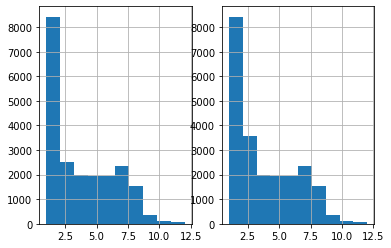

In [45]:
# 'Population Density'   
# desc: Census-based calculation of estimated households per square mile. Twelve ranges from least dense (01 = Very Rural areas - HHs/sq mile less than 29) to most dense (12 = Very Urban - HHs/sq mile greater than 8,167), with the first/lowest 8 ranges each representing approximately 10% of U.S. households and the remaining/highest 4 ranges each representing approximately 5% of U.S. households. Applied at a block group level, with defaulting to ZIP.
# numeric attribute. for now i am filling in with the median value. we can take a closer look at this later to use other attributes to predict the missing values for possible better performance

# how many missing values in 'Population Density'
acxiom_demo['Population Density'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Population Density'].isnull().sum()/len(acxiom_demo)))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# what does the distribution of the 'Population Density' column look like
print(acxiom_demo['Population Density'].value_counts())

# what is the meadian value of the 'Population Density' column. with nice formating "median: 4.0"
print('median: {:.1f}'.format(acxiom_demo['Population Density'].median()))

# make a copy of the 'Population Density' column
copy = acxiom_demo['Population Density'].copy()

# make a histogram of the copy
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Population Density'] = acxiom_demo['Population Density'].fillna(acxiom_demo['Population Density'].median())

# make a second histogram of the 'Population Density' column
acxiom_demo['Population Density'].hist(ax = axes[1])


nan's: 4.7%
15.0    1331
16.0    1281
14.0    1227
18.0    1219
17.0    1192
12.0    1153
13.0    1108
19.0    1077
11.0     995
22.0     967
20.0     919
21.0     886
10.0     682
9.0      677
8.0      589
23.0     587
24.0     561
25.0     556
26.0     533
7.0      413
27.0     406
28.0     306
29.0     294
5.0      275
30.0     227
6.0      223
31.0     198
32.0     183
33.0     174
4.0      166
34.0     133
36.0      96
0.0       94
35.0      85
40.0      65
3.0       63
38.0      55
2.0       53
37.0      43
39.0      32
41.0      23
48.0      23
45.0      15
42.0      15
50.0      13
1.0        8
44.0       7
43.0       5
51.0       5
46.0       5
57.0       3
56.0       2
47.0       2
67.0       2
Name: Population 15+ - % Separated or Divorced, dtype: int64
median: 17.0


<AxesSubplot:>

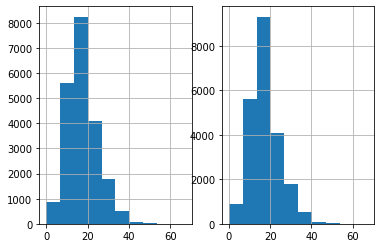

In [46]:
# 'Population 15+ - % Separated or Divorced'   
# numeric attribute. for now i am filling in with the median value. we can take a closer look at this later to use other attributes to predict the missing values for possible better performance

# how many missing values in 'Population 15+ - % Separated or Divorced'
acxiom_demo['Population 15+ - % Separated or Divorced'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Population 15+ - % Separated or Divorced'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Population 15+ - % Separated or Divorced' column look like
print(acxiom_demo['Population 15+ - % Separated or Divorced'].value_counts())

# what is the meadian value of the 'Population 15+ - % Separated or Divorced' column. with nice formating "median: 4.0"
print('median: {:.1f}'.format(acxiom_demo['Population 15+ - % Separated or Divorced'].median()))

# make a copy of the 'Population 15+ - % Separated or Divorced' column
copy = acxiom_demo['Population 15+ - % Separated or Divorced'].copy()

# make 2 subplots of the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# make a histogram of the copy. make it the first subplot
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Population 15+ - % Separated or Divorced'] = acxiom_demo['Population 15+ - % Separated or Divorced'].fillna(acxiom_demo['Population 15+ - % Separated or Divorced'].median())

# make a second histogram of the 'Population 15+ - % Separated or Divorced' column. make it the second subplot
acxiom_demo['Population 15+ - % Separated or Divorced'].hist(ax = axes[1])

nan's: 4.7%
6.0     2711
5.0     2354
4.0     2282
7.0     2246
8.0     1847
3.0     1805
9.0     1647
2.0     1157
10.0    1151
11.0     781
1.0      643
12.0     585
13.0     469
0.0      466
14.0     336
15.0     247
16.0     188
17.0      98
18.0      90
20.0      31
24.0      28
22.0      20
25.0      17
26.0      17
21.0      15
19.0       8
27.0       5
47.0       2
50.0       2
40.0       1
33.0       1
36.0       1
31.0       1
Name: Population 15+ - % Widowed, dtype: int64
median: 6.0


<AxesSubplot:>

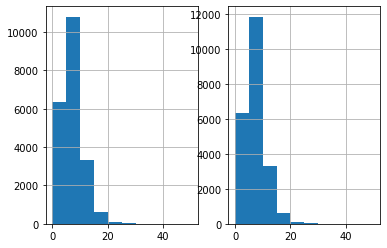

In [47]:
# 'Population 15+ - % Widowed'   
# numeric attribute. for now i am filling in with the median value. i dont really understand this variable we will see if first pass finds it important if not we will remove it. also prehaps there is a better way to backfill the missing values

# how many missing values in 'Population 15+ - % Widowed'
acxiom_demo['Population 15+ - % Widowed'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Population 15+ - % Widowed'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Population 15+ - % Widowed' column look like
print(acxiom_demo['Population 15+ - % Widowed'].value_counts())

# what is the meadian value of the 'Population 15+ - % Widowed' column. with nice formating "median: 4.0"
print('median: {:.1f}'.format(acxiom_demo['Population 15+ - % Widowed'].median()))

# make a copy of the 'Population 15+ - % Widowed' column
copy = acxiom_demo['Population 15+ - % Widowed'].copy()

# make 2 subplots of the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# make a histogram of the copy. make it the first subplot
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Population 15+ - % Widowed'] = acxiom_demo['Population 15+ - % Widowed'].fillna(acxiom_demo['Population 15+ - % Widowed'].median())

# make a second histogram of the 'Population 15+ - % Widowed' column. make it the second subplot
acxiom_demo['Population 15+ - % Widowed'].hist(ax = axes[1])

nan's: 4.7%
3.08    442
3.16    415
2.97    409
2.96    395
3.10    382
       ... 
3.83      1
4.97      1
6.00      1
4.59      1
2.18      1
Name: Families - Average Size, Length: 236, dtype: int64
median: 3.1


<AxesSubplot:>

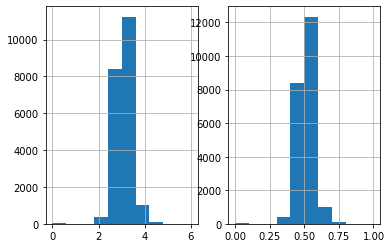

In [48]:
# 'Families - Average Size'   
# numeric attribute. for now i am filling in with the median value. we can take a closer look at this later to use other attributes to predict the missing values for possible better performance

# how many missing values in 'Families - Average Size'
acxiom_demo['Families - Average Size'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Families - Average Size'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Families - Average Size' column look like
print(acxiom_demo['Families - Average Size'].value_counts())

# what is the meadian value of the 'Families - Average Size' column. with nice formating "median: 4.0"
print('median: {:.1f}'.format(acxiom_demo['Families - Average Size'].median()))

# make a copy of the 'Families - Average Size' column
copy = acxiom_demo['Families - Average Size'].copy()

# make 2 subplots of the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# make a histogram of the copy. make it the first subplot
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Families - Average Size'] = acxiom_demo['Families - Average Size'].fillna(acxiom_demo['Families - Average Size'].median())

# standardize the 'Families - Average Size' column to span from 0 to 1
acxiom_demo['Families - Average Size'] = (acxiom_demo['Families - Average Size'] - acxiom_demo['Families - Average Size'].min()) / (acxiom_demo['Families - Average Size'].max() - acxiom_demo['Families - Average Size'].min())

# make a second histogram of the 'Families - Average Size' column. make it the second subplot
acxiom_demo['Families - Average Size'].hist(ax = axes[1])

nan's: 4.7%
median: 778.0


<AxesSubplot:>

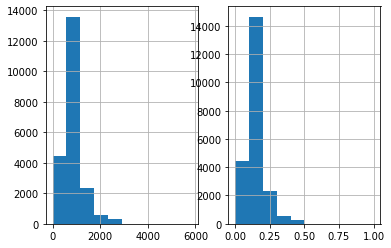

In [49]:
# Family - Average Income (in hundreds of $US)'
# numeric attribute. fill in with the median value. standerdize the attribute.

# how many missing values in 'Families - Average Income (in hundreds of $US)'
acxiom_demo['Family - Average Income (in hundreds of $US)'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Family - Average Income (in hundreds of $US)'].isnull().sum()/len(acxiom_demo)))

# what is the meadian value of the 'Families - Average Income (in hundreds of $US)' column. with nice formating "median: 4.0"
print('median: {:.1f}'.format(acxiom_demo['Family - Average Income (in hundreds of $US)'].median()))

# make a copy of the 'Families - Average Income (in hundreds of $US)' column
copy = acxiom_demo['Family - Average Income (in hundreds of $US)'].copy()

# make 2 subplots of the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# make a histogram of the copy. make it the first subplot
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Family - Average Income (in hundreds of $US)'] = acxiom_demo['Family - Average Income (in hundreds of $US)'].fillna(acxiom_demo['Family - Average Income (in hundreds of $US)'].median())

# standerdize the 'Families - Average Income (in hundreds of $US)' column on a scale of 0 to 1
acxiom_demo['Family - Average Income (in hundreds of $US)'] = (acxiom_demo['Family - Average Income (in hundreds of $US)'] - acxiom_demo['Family - Average Income (in hundreds of $US)'].min()) / (acxiom_demo['Family - Average Income (in hundreds of $US)'].max() - acxiom_demo['Family - Average Income (in hundreds of $US)'].min())

# make a second histogram of the 'Families - Average Income (in hundreds of $US)' column. make it the second subplot
acxiom_demo['Family - Average Income (in hundreds of $US)'].hist(ax = axes[1])


In [50]:
# 'Home Owner / Renter - 100%'   
# categorical attribute. 1 hot encode the attribute

# how many missing values in 'Home Owner / Renter - 100%'
acxiom_demo['Home Owner / Renter - 100%'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Home Owner / Renter - 100%'].isnull().sum()/len(acxiom_demo)))

# one hot encode the 'Home Owner / Renter - 100%' column
acxiom_demo = pd.concat([acxiom_demo, pd.get_dummies(acxiom_demo['Home Owner / Renter - 100%'], prefix = 'Home Owner / Renter - 100%')], axis = 1)

# drop the 'Home Owner / Renter - 100%' column
acxiom_demo = acxiom_demo.drop('Home Owner / Renter - 100%', axis = 1)

nan's: 5.9%


In [51]:
# 'Suppression - Deceased, Bankruptcy, TLJ - Highest'
# categorical attribute. 1 hot encode the attribute

# how many missing values in 'Suppression - Deceased, Bankruptcy, TLJ - Highest'
print(acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].isnull().sum())
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].isnull().sum()/len(acxiom_demo)))

# if 'y' change to 1. if 'n' change to 0. if nan change to 0
acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'] = acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].replace('y', 1)
acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'] = acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].replace('n', 0)
acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'] = acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].fillna(0)

#how many missing values in 'Suppression - Deceased, Bankruptcy, TLJ - Highest'
print(acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].isnull().sum())
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Suppression - Deceased, Bankruptcy, TLJ - Highest'].isnull().sum()/len(acxiom_demo)))

18606
nan's: 83.4%
0
nan's: 0.0%


nan's: 4.7%
919.0     55
2906.0    50
1306.0    47
1763.0    45
2561.0    45
          ..
3967.0     1
4451.0     1
997.0      1
4091.0     1
5053.0     1
Name: Number of People (Total Population), Length: 2097, dtype: int64
median: 1504.0


<AxesSubplot:>

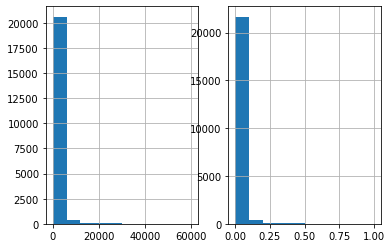

In [52]:
# 'Number of People (Total Population)'   
# continuous attribute. fill in with the median value. standerdize the attribute.

# how many missing values in 'Number of People (Total Population)'
acxiom_demo['Number of People (Total Population)'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Number of People (Total Population)'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Number of People (Total Population)' column look like
print(acxiom_demo['Number of People (Total Population)'].value_counts())

# what is the meadian value of the 'Number of People (Total Population)' column. with nice formating "median: 4.0"
print('median: {:.1f}'.format(acxiom_demo['Number of People (Total Population)'].median()))

# make a copy of the 'Number of People (Total Population)' column
copy = acxiom_demo['Number of People (Total Population)'].copy()

# make 2 subplots of the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# make a histogram of the copy. make it the first subplot
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Number of People (Total Population)'] = acxiom_demo['Number of People (Total Population)'].fillna(acxiom_demo['Number of People (Total Population)'].median())

# standerdize the 'Number of People (Total Population)' column on a scale of 0 to 1
acxiom_demo['Number of People (Total Population)'] = (acxiom_demo['Number of People (Total Population)'] - acxiom_demo['Number of People (Total Population)'].min()) / (acxiom_demo['Number of People (Total Population)'].max() - acxiom_demo['Number of People (Total Population)'].min())

# make a second histogram of the 'Number of People (Total Population)' column. make it the second subplot
acxiom_demo['Number of People (Total Population)'].hist(ax = axes[1])

nan's: 22.9%
18.0    1580
17.0    1570
19.0    1403
20.0    1388
16.0    1356
15.0    1299
14.0    1279
13.0    1070
12.0    1026
11.0     876
10.0     764
9.0      722
8.0      600
7.0      518
6.0      482
5.0      395
4.0      328
3.0      248
2.0      154
1.0      143
Name: Power Video Gamer, dtype: int64
5    11050
4     5004
3     3388
2     1995
1      873
Name: Power Video Gamer, dtype: int64
median: 4.0


<AxesSubplot:>

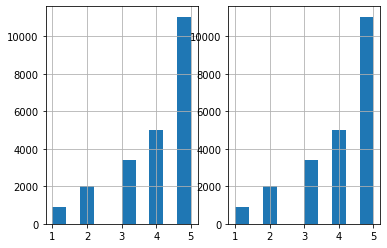

In [53]:
# 'Power Video Gamer'
# desc: Predicts the likelihood of at least one person in the home who has spent at least $400 in the 12 months and played 30 games in the past month.
# numeric attribute. fill in with the median value.

# how many missing values in 'Power Video Gamer'
acxiom_demo['Power Video Gamer'].isnull().sum()
# print with percentage and nice formating "nan's: 0.0%"
print('nan\'s: {:.1%}'.format(acxiom_demo['Power Video Gamer'].isnull().sum()/len(acxiom_demo)))

# what does the distribution of the 'Power Video Gamer' column look like
print(acxiom_demo['Power Video Gamer'].value_counts())

# 20 degree is to much. 5 degree is better
# 1-4 = 1
# 5-8 = 2
# 9-12 = 3
# 13-16 = 4
# 17-20 = 5

# remap the values using a lambda function
acxiom_demo['Power Video Gamer'] = acxiom_demo['Power Video Gamer'].map(lambda x: 1 if x <= 4 else (2 if x <= 8 else (3 if x <= 12 else (4 if x <= 16 else 5))))

# what does the distribution of the 'Power Video Gamer' column look like
print(acxiom_demo['Power Video Gamer'].value_counts())

# what is the meadian value of the 'Power Video Gamer' column. with nice formating "median: 0.0"
print('median: {:.1f}'.format(acxiom_demo['Power Video Gamer'].median()))

# make a copy of the 'Power Video Gamer' column
copy = acxiom_demo['Power Video Gamer'].copy()

# make 2 subplots of the histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

# make a histogram of the copy. make it the first subplot
copy.hist(ax = axes[0])

# fill in the missing values with the median value
acxiom_demo['Power Video Gamer'] = acxiom_demo['Power Video Gamer'].fillna(acxiom_demo['Power Video Gamer'].median())

# make a second histogram of the 'Power Video Gamer' column. make it the second subplot
acxiom_demo['Power Video Gamer'].hist(ax = axes[1])

# reduce  


In [54]:
# drop 'is_suicide'
acxiom_demo = acxiom_demo.drop(columns='is_suicide')

In [55]:
# write the cleaned data to a csv file
acxiom_demo.to_csv('data/out/acxiom_demo_cleaned_v1.csv', index=False)